이미지 확인

In [1]:
!unzip '/content/drive/MyDrive/Colab Notebooks/Flickr.zip' -d Flickr

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: Flickr/Images/2844846111_8c1cbfc75d.jpg  
  inflating: Flickr/Images/2844963839_ff09cdb81f.jpg  
  inflating: Flickr/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Flickr/Images/2845691057_d4ab89d889.jpg  
  inflating: Flickr/Images/2845845721_d0bc113ff7.jpg  
  inflating: Flickr/Images/2846037553_1a1de50709.jpg  
  inflating: Flickr/Images/2846785268_904c5fcf9f.jpg  
  inflating: Flickr/Images/2846843520_b0e6211478.jpg  
  inflating: Flickr/Images/2847514745_9a35493023.jpg  
  inflating: Flickr/Images/2847615962_c330bded6e.jpg  
  inflating: Flickr/Images/2847859796_4d9cb0d31f.jpg  
  inflating: Flickr/Images/2848266893_9693c66275.jpg  
  inflating: Flickr/Images/2848571082_26454cb981.jpg  
  inflating: Flickr/Images/2848895544_6d06210e9d.jpg  
  inflating: Flickr/Images/2848977044_446a31d86e.jpg  
  inflating: Flickr/Images/2849194983_2968c72832.jpg  
  inflating: Flickr/Images/2850719435_221f15e951.jpg  
  inflating: Flickr/Images/28

In [2]:
from glob import glob
files = glob('/content/Flickr/Images/*.jpg')
files[:3]

['/content/Flickr/Images/3585495069_33cba06d0a.jpg',
 '/content/Flickr/Images/3522749949_fb615cee47.jpg',
 '/content/Flickr/Images/3064716525_b8418d4946.jpg']

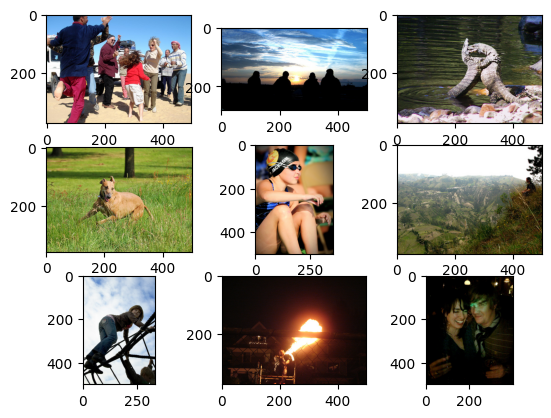

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

for i in range(9):
  plt.subplot(3,3,i+1)
  img = Image.open(files[i+100])
  plt.imshow(img)
plt.show()

학습용 데이터셋
- RGB -> LGB

In [4]:
import cv2
import numpy as np
from torch.utils.data.dataset import Dataset

In [5]:
def rgb2lab(rgb):
  return cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)

def lab2rgb(lab):
  return cv2.cvtColor(lab, cv2.COLOR_RGB2LAB)

In [29]:
from glob import glob
class AutoColoring(Dataset):
  def __init__(self):
    self.data = glob('/content/Flickr/Images/*.jpg')
  def __len__(self):
    return len(self.data)
  def __getitem__(self, index):
    rgb = Image.open(self.data[index]).resize((256,256))
    rgb = np.array(rgb)
    # LAB
    lab = rgb2lab(rgb)  #(256,256,3)  -> (3,256,256)
                        #  0   1  2       2  0   1
    lab = lab.transpose((2,0,1)).astype(np.float32)
    # 흑백채널과 , 색상을 반환 --> 데이터, 정답
    return lab[0], lab[1:]

low label convolution

In [30]:
import torch
import torch.nn as nn

In [31]:
class BasicBlock(nn.Module):
  def __init__(self, in_channel, out_channel,stride) -> None:
    super(BasicBlock,self).__init__()
    self.conv = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,kernel_size=3, stride=stride,padding=1)
    self.bn = nn.BatchNorm2d(out_channel)
    self.sigmoid = nn.Sigmoid()
  def forward(self, x):
    return self.sigmoid( self.bn( self.conv(x) ) )

In [32]:
class LowLevel(nn.Module):
  def __init__(self):
    super(LowLevel,self).__init__()
    self.basic1 = BasicBlock(1, 64, stride=2)
    self.basic2 = BasicBlock(64,128,stride=1)
    self.basic3 = BasicBlock(128,128,stride=2)
    self.basic4 = BasicBlock(128,256,stride=1)
    self.basic5 = BasicBlock(256,256,stride=2)
    self.basic6 = BasicBlock(256,512,stride=1)
  def forward(self,x):
    # (1,256,256) -> 1: (64,128, 128) -> 2: (128,128, 128) -> 3: (128,64, 64)
    # 4: (256,64, 64) -> 5: (256,32, 32) -> 6: (512, 32, 32)
    x = self.basic1(x); x = self.basic2(x); x = self.basic3(x)
    x = self.basic4(x); x = self.basic5(x); x = self.basic6(x)
    return x

middle level

In [33]:
class MidLevel(nn.Module):
  def __init__(self) -> None:
    super(MidLevel,self).__init__()
    self.basic1 = BasicBlock(in_channel= 512,out_channel= 512, stride=1)
    self.basic2 = BasicBlock(in_channel= 512,out_channel= 256, stride=1)
  def forward(self,x):
    x = self.basic1(x)
    x = self.basic2(x)
    return x

Global level

In [34]:
class GlobalLevel(nn.Module):
  def __init__(self):
    super(GlobalLevel,self).__init__()
    self.basic1 = BasicBlock(512,512, stride=2)
    self.basic2 = BasicBlock(512,512, stride=1)
    self.basic3 = BasicBlock(512,512, stride=2)
    self.basic4 = BasicBlock(512,512, stride=1)
    # (512, 32, 32) -> 1: (512, 16, 16) -> 2: (512, 16, 16)
    # 3: (512, 8, 8) -> 4: (512, 8, 8)
    # 512 *8 * 8 = 32768
    self.fc1 = nn.Linear(in_features = 512*8*8, out_features = 1024)
    self.fc2 = nn.Linear(in_features = 1024, out_features = 512)
    self.fc3 = nn.Linear(in_features = 512, out_features = 256)
    self.sigmoid = nn.Sigmoid()
  def forward(self,x):
    x = self.basic1(x); x = self.basic2(x); x = self.basic3(x); x = self.basic4(x)
    # (batch_size, 512 ,8 , 8 )
    x = torch.flatten(x, start_dim=1)
    x = self.sigmoid(self.fc1(x))
    x = self.sigmoid(self.fc2(x))
    x = self.sigmoid(self.fc3(x))
    return x

Colorization 신경망

In [35]:
class Colorization(nn.Module):
  def __init__(self):
    super(Colorization,self).__init__()
    # 업셈플링
    self.color1 = nn.ConvTranspose2d(in_channels=256, out_channels=128,kernel_size=3,stride=1,padding=1)
    self.bn1 = nn.BatchNorm2d(128)

    self.color2 = nn.ConvTranspose2d(in_channels=128, out_channels=64,kernel_size=2,stride=2)
    self.bn2 = nn.BatchNorm2d(64)

    self.color3 = nn.ConvTranspose2d(in_channels=64, out_channels=64,kernel_size=3,stride=1,padding=1)
    self.bn3 = nn.BatchNorm2d(64)

    self.color4 = nn.ConvTranspose2d(in_channels=64, out_channels=32,kernel_size=2,stride=2)
    self.bn4 = nn.BatchNorm2d(32)

    self.color5 = nn.ConvTranspose2d(in_channels=32, out_channels=2,kernel_size=2,stride=2)
    self.sigmoid = nn.Sigmoid()
  def forward(self,x):
    x = self.sigmoid( self.bn1( self.color1(x) ) )
    x = self.sigmoid( self.bn2( self.color2(x) ) )
    x = self.sigmoid( self.bn3( self.color3(x) ) )
    x = self.sigmoid( self.bn4( self.color4(x) ) )
    x = self.color5(x)
    return x

자동 채색 모델 정의

In [36]:
class AutoColoringModel(nn.Module):
  def __init__(self):
    super(AutoColoringModel,self).__init__()
    self.low = LowLevel()
    self.mid = MidLevel()
    self.glob = GlobalLevel()
    # 특성 합치기
    self.fusion = nn.Conv2d(512,256,kernel_size=3,stride=1,padding=1)
    # 색 입히기
    self.color = Colorization()
    # 활성화 함수
    self.sigmoid = nn.Sigmoid()
  def forward(self ,x):
    x = self.low(x)
    mid = self.mid(x)
    glo = self.glob(x)

    # 글로벌은 MLP층을 통과한 1차원 데이터 ->미들레벨의 크기만큼 반복해서 쌓아야 함
    fusion = glo.repeat(1, mid.shape[2]*mid.shape[2])
    fusion = torch.reshape(fusion, (-1, 256,mid.shape[2],mid.shape[2])   )
    fusion = torch.cat([mid,fusion],dim=1)
    fusion = self.fusion(fusion)
    fusion = self.sigmoid(fusion)

    color = self.color(fusion)
    return color

모델 학습하기

In [37]:
import tqdm
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam
device = "cuda" if torch.cuda.is_available() else 'cpu'
model = AutoColoringModel().to(device)

In [38]:
# 데이터 로더 batch 32 shuffle
dataset = AutoColoring()
loader = DataLoader(dataset, batch_size=32, shuffle=True)
optim = Adam(model.parameters(), lr = 0.01)

In [39]:
for epoch in range(10):
  iterator = tqdm.tqdm(loader)
  for L, AB in iterator:  # original L  (256,256)
    L = torch.unsqueeze(L,dim=1).to(device)
    optim.zero_grad()  # 기울기 초기화
    pred = model(L)
    loss = nn.MSELoss()(pred,AB.to(device))
    loss.backward()
    optim.step()
    iterator.set_description(f"epoch:{epoch+1} loss:{loss.item()}")

epoch:10 loss:304.2606506347656: 100%|██████████| 253/253 [02:38<00:00,  1.59it/s]


In [40]:
torch.save(model.state_dict(),"/content/drive/MyDrive/AutoColoring.pth")

모델 성능 평가

In [56]:
test_L, test_AB =  dataset[0]
test_L = np.expand_dims(test_L,axis=0)
real_img =  np.concatenate([test_L, test_AB])
real_img  = real_img.transpose(1,2,0).astype(np.uint8)
real_img = lab2rgb(real_img)

torch.Size([1, 1, 256, 256])
torch.Size([1, 2, 256, 256])


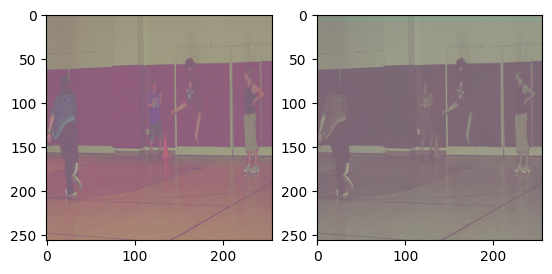

In [57]:
with torch.no_grad():
  model.load_state_dict(torch.load('/content/drive/MyDrive/AutoColoring.pth',map_location=device))

  input_tensor = torch.tensor(test_L)
  input_tensor = torch.unsqueeze(input_tensor,dim=0).to(device)
  print(input_tensor.shape)
  pred_AB = model(input_tensor)
  print(pred_AB.shape)

  pred_LAB = torch.cat([input_tensor,pred_AB],dim=1)
  pred_LAB = torch.squeeze(pred_LAB)
  pred_LAB = pred_LAB.permute(1,2,0).cpu().numpy()
  pred_LAB = lab2rgb(pred_LAB.astype(np.uint8))

plt.subplot(1,2,1)
plt.imshow(real_img)

plt.subplot(1,2,2)
plt.imshow(pred_LAB)

plt.show()

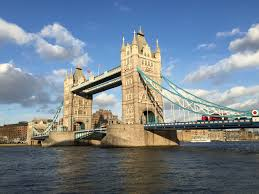

In [45]:
from PIL import Image
import matplotlib.pyplot as plt
test_L = Image.open('/content/Londo.jpg')
test_L

In [60]:
import torch
import numpy as np
device = "cuda" if torch.cuda.is_available() else 'cpu'
model = AutoColoringModel().to(device)

test_L = Image.open('/content/Londo.jpg').resize((256,256))
test_L = np.array(test_L)
test_L = np.expand_dims(test_L,axis=0).astype(np.float32)


with torch.no_grad():
  # 자료 부적합 - 적합한 이미지로 다시 실행 필요
  model.load_state_dict(torch.load('/content/drive/MyDrive/AutoColoring.pth',map_location=device))

  input_tensor = torch.tensor(test_L)
  input_tensor = torch.squeeze(input_tensor, dim=0)
#  input_tensor = torch.unsqueeze(input_tensor,dim=0).to(device)
  input_tensor = input_tensor.squeeze(0)
  print(input_tensor.shape, type(input_tensor))
  pred_AB = model(input_tensor)
  print(pred_AB.shape)

  pred_LAB = torch.cat([input_tensor,pred_AB],dim=1)
  pred_LAB = torch.squeeze(pred_LAB)
  pred_LAB = pred_LAB.permute(1,2,0).cpu().numpy()
  pred_LAB = lab2rgb(pred_LAB.astype(np.uint8))


plt.imshow(pred_LAB)

plt.show()

torch.Size([256, 256, 3]) <class 'torch.Tensor'>


RuntimeError: Given groups=1, weight of size [64, 1, 3, 3], expected input[1, 256, 256, 3] to have 1 channels, but got 256 channels instead

In [58]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

device = "cuda" if torch.cuda.is_available() else 'cpu'

# 모델 정의
model = AutoColoringModel().to(device)

# 테스트 이미지 로드 및 전처리
test_L = Image.open('/content/Londo.jpg').resize((256,256))
test_L = np.array(test_L)
test_L = np.expand_dims(test_L, axis=0).astype(np.float32)

# 모델 가중치 로드
with torch.no_grad():
    model.load_state_dict(torch.load('/content/drive/MyDrive/AutoColoring.pth', map_location=device))
    model.eval()

    # 입력 텐서 준비
    input_tensor = torch.tensor(test_L).to(device)
    #input_tensor = torch.unsqueeze(input_tensor,dim=0).to(device)  # 배치 차원 추가
    input_tensor = torch.squeeze(input_tensor, dim=0)


    # 모델 추론
    pred_AB = model(input_tensor)

# LAB 이미지 재구성
input_tensor = input_tensor.squeeze(0)
pred_LAB = torch.cat([input_tensor, pred_AB], dim=1)
pred_LAB = pred_LAB.squeeze(0)
pred_LAB = pred_LAB.permute(1, 2, 0).cpu().numpy()

# LAB에서 RGB로 변환
pred_RGB = lab2rgb(pred_LAB.astype(np.uint8))

# 이미지 시각화
plt.imshow(pred_RGB)
plt.axis('off')
plt.show()


RuntimeError: Given groups=1, weight of size [64, 1, 3, 3], expected input[1, 256, 256, 3] to have 1 channels, but got 256 channels instead